## Libraries

### Install packages and download models

In [2]:
!pip install bertopic
!python -m spacy download en_core_web_md

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 12.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Imports

In [3]:
import numpy as np
import pandas as pd
from gensim import corpora, models
import spacy
from spacy.lang.en import stop_words
from tqdm import tqdm
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification
import matplotlib.pyplot as plt
import os
import logging
import re

# spaCy NLP
nlp = spacy.load("en_core_web_md")

## Preprocess text

### Filter out non-English documents

In [ ]:
# https://huggingface.co/papluca/xlm-roberta-base-language-detection
model_ckpt = "papluca/xlm-roberta-base-language-detection"
pipe = pipeline("text-classification", model=model_ckpt)

df_blogs = pd.read_csv("blogs.csv").dropna(subset="blog")
for i, row in tqdm(df_blogs.iterrows()):
    blog = row["blog"]

    blog = blog.strip()
    lang = pipe(blog, truncation=True)

    df_blogs.loc[i, "blog"] = blog
    df_blogs.loc[i, "lang"] = lang[0]["label"]

df_blogs = df_blogs[df_blogs["lang"] == "en"]
df_blogs.to_csv("blogs.csv")

Device set to use cpu
3138it [58:25,  1.12s/it]


### Named entity recognition

In [4]:
df_blogs = pd.read_csv("blogs.csv", index_col=0)

# Named entity recognition model
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
ner = pipeline("ner", model=model, tokenizer=tokenizer)

for index, row in tqdm(df_blogs.iterrows()):
  ner_res = ner(row["blog"]) # Run NER model on blog

  # Apply some post-processing to concatenate tokens
  ner_res_post_proc = []
  for i, res in enumerate(ner_res):
    if res["word"].startswith("##"):
      # Don't append if it's part of a word
      continue
    elif i != len(ner_res) - 1:
      # If it's not the last element in the list
      j = 1
      full_res = res
      full_res["entity"] = res["entity"].replace("B-LOC", "LOC").replace("I-LOC", "LOC").replace("B-PER", "PER").replace("I-PER", "PER")
      while ner_res[i + j]["word"].startswith("##"):
        next_res = ner_res[i + j]
        full_res["word"] += next_res["word"].replace("##", "")
        full_res["end"] = next_res["end"]


        # If end is reached, stop. Else continue
        if i + j == len(ner_res) - 1:
          break
        else:
          j += 1

      ner_res_post_proc.append(full_res)

  # Replace tokens by their entity
  ner_blog = row["blog"]
  len_change = 0
  for res in ner_res_post_proc:
    ner_blog = ner_blog[:res["start"] - len_change] + res["entity"] + ner_blog[res["end"] - len_change:]
    len_change += len(res["word"]) - 3

  df_blogs.loc[index, "ner_blog"] = ner_blog

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
2967it [1:05:05,  1.32s/it]


In [5]:
df_blogs

,Unnamed: 0,blog,lang,ner_blog
0,0,At Owhango after 20kms we went across latitude...,en,At LOC after 20kms we went across latitude 39d...
1,1,"Ohakune is about 800metres high, don't know wh...",en,"LOC is about 800metres high, don't know what t..."
2,2,"Well, we had an interesting, varied and a good...",en,"Well, we had an interesting, varied and a good..."
3,3,Overnight we had to endure a variety of barkin...,en,Overnight we had to endure a variety of barkin...
4,4,A chalk and cheese day with 35kms of flat road...,en,A chalk and cheese day with 35kms of flat road...
...,...,...,...,...
3278,139,"And, boy, do I eat some good food over these t...",en,"And, boy, do I eat some good food over these t..."
3279,140,"Come December, I'm in Christchurch, and a quic...",en,"Come December, I'm in LOC, and a quick search ..."
3280,141,It promises therefore to be an uninteresting d...,en,It promises therefore to be an uninteresting d...
3281,142,What easy tour do I choose to entertain myself...,en,What easy tour do I choose to entertain myself...


In [7]:
df_blogs.to_csv("blogs.csv")

### Apply standard preprocessing

In [8]:
stop_words_to_use = list(stop_words.STOP_WORDS)
stop_words_to_use += ["ride", "rides", "riding", "cycling", "cycle", "bycycling", "tour", "touring", "day", "bike", "bikes", "road", "get", "go", "mile", "miles", "km", "kms", "metre", "like", "way", "good", "come", "look", "nice", "think", "trip", "know", "see", "great", "today", "distance", "malawi", "zambia", "auckland", "strasbourg", "pyrenees", "bordeaux", "andorra", "paris", "france"]

In [10]:
# https://spacy.io/usage/linguistic-features


def preprocess_text(file_path, nlp, ner_blogs=False, stop_word_removal=True, non_alpha_removal=True, lemmatization=True, lowercasing=True, stop_words_to_use=[]):
    df_blogs = pd.read_csv(file_path)
    documents = []

    for i, row in tqdm(df_blogs.iterrows()):
        if ner_blogs:
          doc = nlp(row["ner_blog"]) # Convert to spaCy doc
        else:
          doc = nlp(row["blog"]) # Convert to spaCy doc

        if len(doc) > 1:
            if non_alpha_removal: # Remove non alpha characters
                doc = [token for token in doc if token.is_alpha]

            if lemmatization: # Lemmatize words
                doc = [token.lemma_ for token in doc]

            if stop_word_removal: # Remove stop words
                doc = [token for token in doc if token not in stop_words_to_use]

            if lowercasing: # Lowercase words
                doc = [token.lower() for token in doc]

            documents.append(doc)

    # https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html
    dictionary = corpora.Dictionary(documents)
    dictionary.filter_extremes(no_below=2) # Filter out tokens appearing only once
    corpus = [dictionary.doc2bow(doc) for doc in documents]

    if ner_blogs:
      dictionary.save("ner_dictionary.dict")
      corpora.MmCorpus.serialize("ner_corpus.mm", corpus)
    else:
      dictionary.save("dictionary.dict")
      corpora.MmCorpus.serialize("corpus.mm", corpus)


preprocess_text("blogs.csv", nlp, ner_blogs=True, stop_words_to_use=stop_words_to_use)


2967it [04:57,  9.97it/s]


## Explore dictionary

In [12]:
# https://radimrehurek.com/gensim/auto_examples/core/run_topics_and_transformations.html
dictionary = corpora.Dictionary.load("ner_dictionary.dict")
corpus = corpora.MmCorpus("ner_corpus.mm")

word_freq = {k: v for k, v in sorted(dictionary.cfs.items(), key=lambda item: item[1], reverse=True)}
for id in list(word_freq.keys())[:50]:
    print(dictionary[id])

time
stop
town
find
per
start
ori
hill
little
head
leave
night
place
mii
long
turn
pass
wind
rain
people
lot
right
climb
feel
hour
route
big
bit
water
want
tell
thing
eat
end
pretty
home
park
misc
stay
decide
use
area
camp
walk
morning
try
lunch
work
rest
far


## Modelling

In [13]:
# Allow logging
logging.basicConfig(filename='gensim.log', format='%(asctime)s:%(levelname)s:%(message)s', level=logging.INFO)


def clear_logfile():
    # To empty the log file
    with open("gensim.log", "w"):
        pass


def parse_logfile():
    """Parse gensim.log to extract the log-likelihood scores.

    Returns:
        A list of log-likelihood scores.
    """
    matcher = re.compile(r'(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity')
    likelihoods = []
    with open('gensim.log') as source:
        for line in source:
            match = matcher.search(line)
            if match:
                likelihoods.append(float(match.group(1)))
    return likelihoods

In [16]:
df_blogs

,Unnamed: 0,blog,lang,ner_blog
0,0,At Owhango after 20kms we went across latitude...,en,At LOC after 20kms we went across latitude 39d...
1,1,"Ohakune is about 800metres high, don't know wh...",en,"LOC is about 800metres high, don't know what t..."
2,2,"Well, we had an interesting, varied and a good...",en,"Well, we had an interesting, varied and a good..."
3,3,Overnight we had to endure a variety of barkin...,en,Overnight we had to endure a variety of barkin...
4,4,A chalk and cheese day with 35kms of flat road...,en,A chalk and cheese day with 35kms of flat road...
...,...,...,...,...
3278,139,"And, boy, do I eat some good food over these t...",en,"And, boy, do I eat some good food over these t..."
3279,140,"Come December, I'm in Christchurch, and a quic...",en,"Come December, I'm in LOC, and a quick search ..."
3280,141,It promises therefore to be an uninteresting d...,en,It promises therefore to be an uninteresting d...
3281,142,What easy tour do I choose to entertain myself...,en,What easy tour do I choose to entertain myself...


### LDA

Topic 0: mii, people, find, park, river, stop, town, head, trail, time
Topic 1: aunt, pool, st, till, vegas, buffet, louis, m, night, â
Topic 2: car, tell, canal, path, bridge, stop, trail, train, hill, route
Topic 3: route, work, thing, ori, cycle, per, week, plan, year, time
Topic 4: tent, stuff, small, use, sleep, water, thank, ori, bag, per
Topic 5: rear, joyce, time, phil, new, ori, tube, start, flat, tire
Topic 6: russ, hurtle, fab, guinness, experiment, freaky, pirate, unladen, rah, wierd
Topic 7: hostel, camp, head, shop, turn, misc, org, rt, mii, ori
Topic 8: pass, little, wind, start, climb, find, town, hill, time, stop
Topic 9: walk, lunch, food, mii, time, place, campsite, stop, town, ori


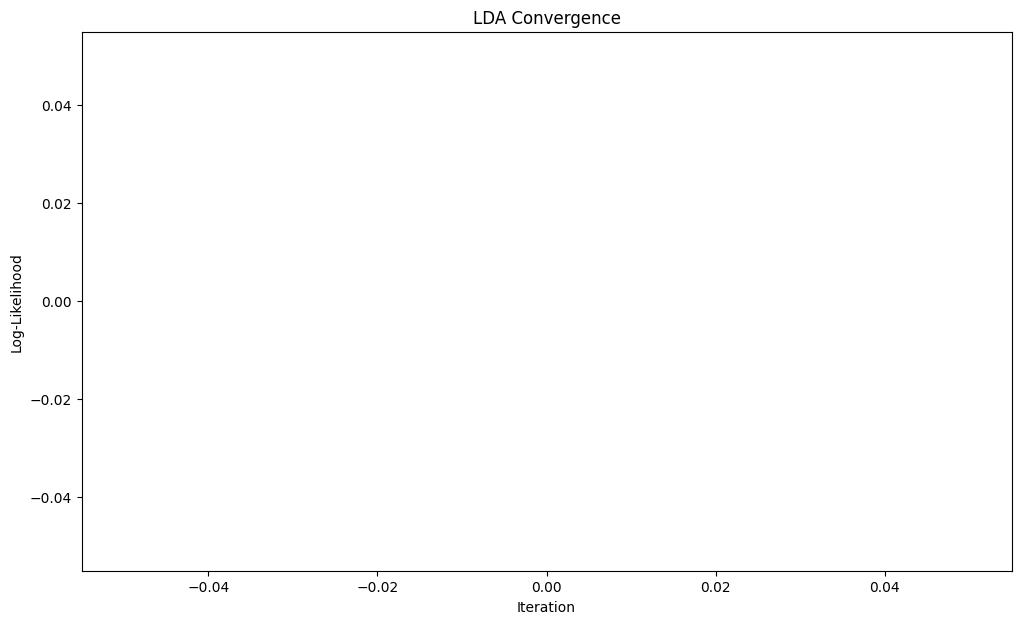

In [17]:
%%timeit

tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# https://radimrehurek.com/gensim/models/ldamodel.html
# https://stackoverflow.com/questions/37570696/how-to-monitor-convergence-of-gensim-lda-model
clear_logfile()
lda = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=50, eval_every=10)
likelihoods = parse_logfile()

# Plot likelihoods for convergence
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(likelihoods)
ax.set(title="LDA Convergence", xlabel="Iteration", ylabel="Log-Likelihood")

# Print most important words per topic
topics = lda.get_topics()
for topic in range(10):
    topic_probs = topics[topic, :]
    print(f"Topic {topic}: {', '.join([dictionary[i] for i in np.argsort(topic_probs)[-10:]])}")

In [18]:
# https://maartengr.github.io/BERTopic/getting_started/tips_and_tricks/tips_and_tricks.html
# https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html

from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from hdbscan import HDBSCAN
from bertopic import BERTopic

In [ ]:
%%timeit

df_blogs = df_blogs.reset_index(drop=True)

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(df_blogs.blog)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
%%timeit

hdbscan_model = HDBSCAN(min_cluster_size=50) # Clustering step
vectorizer_model = CountVectorizer(stop_words=stop_words_to_use) # Tokenizer step
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True) # c-TF-IDF step
representation_model = KeyBERTInspired() # Fine-tuning step
topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model, ctfidf_model=ctfidf_model, representation_model=representation_model)
topics, probs = topic_model.fit_transform(df_blogs.blog, embeddings)

In [ ]:
topic_model.get_topic_info()

Idea: somehow score how relevant sentences are to touring style and then remove sentences below a certain threshold. Then apply topic modelling.